In [29]:
import json
import pandas as pd

In [30]:
tp_results = pd.read_json("tp_results.jsonl", lines=True)
cp_results = pd.read_json("cp_results.jsonl", lines=True)

# filter and only take the config_name == "llama7b"
tp_results = tp_results[tp_results['config_name'] == "llama7b"]
cp_results = cp_results[cp_results['config_name'] == "llama7b"]


In [31]:
tp_results.head()


,tp_size,config_name,config,batch_size,seq_len_factor,seq_len,compute_duration_ms,comm_duration_ms
0,4,llama7b,"{'head_dim': 128, 'num_qo_heads': 32, 'num_kv_...",1,10,1024,2.431424,0.053067
1,4,llama7b,"{'head_dim': 128, 'num_qo_heads': 32, 'num_kv_...",1,11,2048,0.270784,0.079260
2,4,llama7b,"{'head_dim': 128, 'num_qo_heads': 32, 'num_kv_...",1,12,4096,0.503552,0.116961
3,4,llama7b,"{'head_dim': 128, 'num_qo_heads': 32, 'num_kv_...",1,13,8192,1.341024,0.191836
4,4,llama7b,"{'head_dim': 128, 'num_qo_heads': 32, 'num_kv_...",1,14,16384,3.747808,0.305205


In [32]:
cp_results.head()

,cp_size,config_name,config,batch_size,seq_len_factor,seq_len,allcomputeandcomm,compute_duration_ms,comm_duration_ms
0,4,llama7b,"{'head_dim': 128, 'num_qo_heads': 32, 'num_kv_...",1,10,1024,"{'compute_times': [0.47347199916839605, 0.4831...",2.444288,4.848096
1,4,llama7b,"{'head_dim': 128, 'num_qo_heads': 32, 'num_kv_...",1,11,2048,"{'compute_times': [0.16124799847602803, 0.1604...",0.161664,2.979648
2,4,llama7b,"{'head_dim': 128, 'num_qo_heads': 32, 'num_kv_...",1,12,4096,"{'compute_times': [0.20505599677562703, 0.1966...",0.220320,4.665472
3,4,llama7b,"{'head_dim': 128, 'num_qo_heads': 32, 'num_kv_...",1,13,8192,"{'compute_times': [0.8488640189170831, 0.72240...",0.875168,2.494208
4,4,llama7b,"{'head_dim': 128, 'num_qo_heads': 32, 'num_kv_...",1,14,16384,"{'compute_times': [0.6297919750213621, 0.67119...",0.671200,8.809440


In [33]:
tp_results['duration_ms'] = tp_results['compute_duration_ms'] + tp_results['comm_duration_ms']
cp_results['duration_ms'] = cp_results['compute_duration_ms'] + cp_results['comm_duration_ms']

In [34]:
# Plot the heatmap for tp_results (x=batch_size, y=seq_len_factor, value=compute_duration_ms+comm_duration_ms)
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table for tp_results
tp_pivot = tp_results.pivot_table(index='seq_len_factor', columns='batch_size', values='duration_ms', aggfunc='sum')

In [35]:
cp_pivot = cp_results.pivot_table(index='seq_len_factor', columns='batch_size', values='duration_ms', aggfunc='sum')

In [36]:
# Display the pivot tables with float values rounded to 2 decimal places
tp_pivot_rounded = tp_pivot.round(2)
cp_pivot_rounded = cp_pivot.round(2)

In [37]:
tp_pivot_rounded

batch_size,1,2,4,8,16
seq_len_factor,,,,,
10,2.48,0.30,0.38,0.51,0.73
11,0.35,0.41,0.59,0.86,1.52
12,0.62,0.81,1.30,2.21,4.01
13,1.53,2.06,3.68,6.80,14.15
14,4.05,6.43,12.16,25.81,50.66
15,26.04,22.81,48.94,96.73,183.93
16,47.38,95.50,188.88,369.68,695.06
17,190.54,358.41,715.61,1398.03,2774.99
18,723.88,1432.50,2839.57,5674.62,11325.92


In [38]:
cp_pivot_rounded

batch_size,1,2,4,8
seq_len_factor,,,,
10,7.29,8.91,12.53,5.67
11,3.14,9.32,3.46,9.42
12,4.89,10.53,2.26,5.22
13,3.37,2.41,9.86,4.21
14,9.48,3.43,5.79,7.02
15,4.27,6.23,11.68,19.78
16,9.00,16.40,90.84,62.04
17,27.19,56.47,140.32,206.98
18,164.98,208.35,363.08,727.19


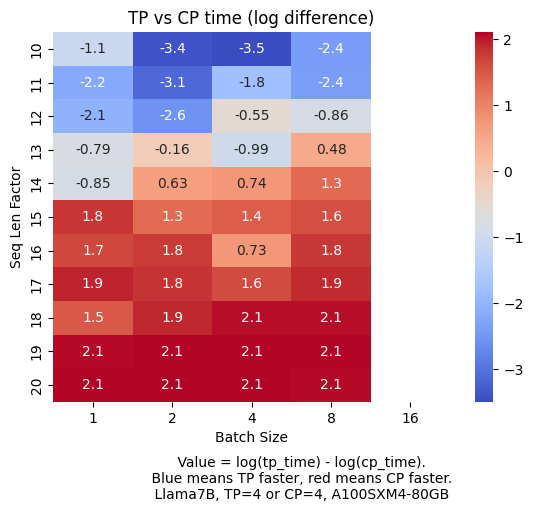

In [45]:
# Great. Now compare the tp and cp pivot table (if no value then just ignore that cell) using a log difference of `log(tp) - log(cp)`.
import numpy as np

tp_cp_log_diff = np.log(tp_pivot_rounded) - np.log(cp_pivot_rounded)
tp_cp_log_diff
# Plot the heatmap for tp_cp_log_diff
plt.title("TP vs CP time (log difference)")
sns.heatmap(tp_cp_log_diff, annot=True, cmap='coolwarm')
plt.xlabel('Batch Size')
plt.ylabel('Seq Len Factor')
plt.figtext(
    0.5, -0.05, """
    Value = log(tp_time) - log(cp_time).
    Blue means TP faster, red means CP faster.
    Llama7B, TP=4 or CP=4, A100SXM4-80GB
""", 
    ha='center', va='center'
)
plt.show()
